In [19]:
import os
from functools import wraps
from collections import defaultdict
from tqdm import tqdm


from logdeep.tools.predict import generate
from collections import Counter
from logdeep.models.lstm import deeplog, loganomaly, robustlog
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *
# from logdeep.dataset.mylog import log_dataset
from logdeep.dataset.log import log_dataset
from logdeep.dataset.sample_finetune import sliding_window, session_window
from logdeep.tools.utils import (save_parameters, seed_everything,
                                 train_val_split)

import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
import copy
import random
import time
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from argparse import ArgumentParser
from torchvision import transforms as tt
from PIL import Image
from utils import AverageMeter

In [20]:
# set manual seed for reproducibility
seed = 1234

In [21]:
# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [22]:
# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
# Hyperparameters_List (H) = [rounds, client_fraction, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client]

stop_gradient = True
has_predictor = True
OneLayer = "1_layer"
TwoLayer = "2_layer"
predictor_network=TwoLayer
global_epochs = 200
client_fraction = 1.0
client_num = 5
local_epoch = 5
batch_size = 512
lr = 3e-4
partition = 'iid'
norm = 'bn'
alpha_partition = 0.5
sch_flag = False
iid = False
avg_freq = 1

data_portion = 1.0
noniid_ratio = 1.0
# noniid_ratio = 0.55

# save_path = f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSLMaxpool_deeplog/SplitFSSLdeeplog_log_{batch_size}_{noniid_ratio}_{client_num}"
# save_path = f"./model/SplitFSSL_SimCLR_deeplog/resnet18log_simclr_{batch_size}_{noniid_ratio}_{client_num}"
save_path = f"./model/SplitFSSL_SimSiam_deeplog/resnet18log_simsiam_{batch_size}_{noniid_ratio}_{client_num}"

H = [global_epochs, client_fraction, client_num, local_epoch, batch_size, lr]

In [24]:
logoptions = dict()
logoptions['data_dir'] = './data/'
logoptions['window_size'] = 10
logoptions['device'] = "cpu"

# Smaple
logoptions['sample'] = "sliding_window"
logoptions['window_size'] = 10  # if fix_window

# Features
logoptions['sequentials'] = True
logoptions['quantitatives'] = False
logoptions['semantics'] = False
logoptions['feature_num'] = sum(
    [logoptions['sequentials'], logoptions['quantitatives'], logoptions['semantics']])

In [25]:
if logoptions['sample'] == 'sliding_window':
    train_logs, train_labels = sliding_window(logoptions['data_dir'],
                                              datatype='train',
                                              window_size=logoptions['window_size'],
                                              clientnum = client_num)
    # val_logs, val_labels = sliding_window(logoptions['data_dir'],
    #                                           datatype='val',
    #                                           window_size=logoptions['window_size'],
    #                                           clientnum = client_num)

File ./data/hdfs/hdfs_train, number of seqs 46575


In [26]:
train_dataset = log_dataset(logs=train_logs,
                            labels=train_labels,
                            seq=logoptions['sequentials'],
                            quan=logoptions['quantitatives'],
                            sem=logoptions['semantics'])

# val_dataset = log_dataset(logs=val_logs,
#                             labels=val_labels,
#                             seq=logoptions['sequentials'],
#                             quan=logoptions['quantitatives'],
#                             sem=logoptions['semantics'])

In [27]:
train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True)
# val_loader = DataLoader(val_dataset,
#                             batch_size=batch_size,
#                             shuffle=True)

In [28]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

In [29]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

In [30]:
def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(
            current_model.parameters(), ma_model.parameters()
    ):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)


def byol_loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

In [31]:
class MLP(nn.Module):
    def __init__(self, dim, projection_size, hidden_size=4096, class_num=10, num_layer=TwoLayer):
        super().__init__()
        self.in_features = dim
        if num_layer == OneLayer:
            self.net = nn.Sequential(
                nn.Linear(dim, projection_size),
            )
        elif num_layer == TwoLayer:
            self.net = nn.Sequential(
                nn.Linear(dim, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_size, projection_size),
            )
        else:
            raise NotImplementedError(f"Not defined MLP: {num_layer}")

    def forward(self, x):
        return self.net(x)
        
class Classifer(nn.Module):
    def __init__(self, dim, hidden_size=1024, class_num=10):
        super().__init__()
        self.in_features = dim
        
        self.fc1 = nn.Linear(dim, hidden_size)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.softmax = nn.Softmax(dim=1)
        self.fc3 = nn.Linear(hidden_size, class_num)

    def forward(self, x):
        
        x = self.fc1(x)
        # x = self.relu(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        x = self.fc3(x)
        
        return x

In [32]:
import os
import argparse
import pickle
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import SequentialSampler
from torchvision import datasets, models, transforms

In [33]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [34]:
def inference(loader, model, device):
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        input0 = x
        h0 = torch.zeros(2, input0.size(0), 64).to(device)
        c0 = torch.zeros(2, input0.size(0), 64).to(device)
        # get encoding
        with torch.no_grad():
            # h = model(x)
            out, _ = model(x)
        
        h = out[:, -1, :]

        h = h.squeeze()
        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 5 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

def get_features(model, train_loader, device):
    train_X, train_y = inference(train_loader, model, device)
    return train_X, train_y
# def get_features(model, train_loader, test_loader, device):
#     train_X, train_y = inference(train_loader, model, device)
#     test_X, test_y = inference(test_loader, model, device)
#     return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )
        
    return train_loader

In [35]:
resnet = deeplog(input_size=1, hidden_size=64, num_layers=2, num_keys=28)
resnet.fc = MLP(64, 28, 64)
resnet.load_state_dict(torch.load(save_path + "_final.pt", map_location=device))
# resnet.load_state_dict(torch.load(save_path + "_200_epoch.pt", map_location=device))
# resnet.load_state_dict(torch.load(f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_20_1.0_0904_final.pt", map_location=device))
# resnet.load_state_dict(torch.load(f"./model/FedAvg_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_{client_num}_final.pt", map_location=device))
print(save_path + "_final.pt")
# print(save_path + "_200_epoch.pt")
resnet = resnet.to(device)

./model/SplitFSSL_SimSiam_deeplog/resnet18log_simsiam_512_1.0_5_final.pt


In [36]:
resnet

deeplog(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): MLP(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=64, out_features=28, bias=True)
    )
  )
)

In [37]:
# throw away fc layer
num_features = list(resnet.children())[-1].in_features
n_classes = 28 # 28 classes(key) in deeplog 
resnet = nn.Sequential(*list(resnet.children())[:-1])

# fine-tune model
# logreg = Classifer(num_features, hidden_size=1024)
logreg = nn.Sequential(nn.Linear(num_features, n_classes))
logreg = logreg.to(device)
models = [copy.deepcopy(logreg).to(device) for idx in range(client_num)]
models_weights = [1/5 for i in range(client_num)]

In [38]:
resnet

Sequential(
  (0): LSTM(1, 64, num_layers=2, batch_first=True)
)

In [39]:
epochs = 200
# loss / optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=logreg.parameters(), lr=0.001)
optimizer_models = [torch.optim.Adam(models[i].parameters(), lr =0.001) for i in range(len(models))]
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)

In [40]:
print("Creating features from pre-trained model")
(train_X, train_y) = get_features(
    resnet, train_loader, device
)

Creating features from pre-trained model
Step [0/91]	 Computing features...
Step [5/91]	 Computing features...
Step [10/91]	 Computing features...
Step [15/91]	 Computing features...
Step [20/91]	 Computing features...
Step [25/91]	 Computing features...
Step [30/91]	 Computing features...
Step [35/91]	 Computing features...
Step [40/91]	 Computing features...
Step [45/91]	 Computing features...
Step [50/91]	 Computing features...
Step [55/91]	 Computing features...
Step [60/91]	 Computing features...
Step [65/91]	 Computing features...
Step [70/91]	 Computing features...
Step [75/91]	 Computing features...
Step [80/91]	 Computing features...
Step [85/91]	 Computing features...
Step [90/91]	 Computing features...
Features shape (46575, 64)


In [23]:
# test_y_dict, classes_dict = noniid_testdata_label(test_y, client_num, noniid_ratio, num_class=10)
# train_y_dict, _ = noniid_testdata_label(train_y, client_num, noniid_ratio, num_class=10)

# Fine tuning by all training data

In [41]:
train_loader = create_data_loaders_from_arrays(train_X, train_y, 2048)

In [42]:
# Train fine-tuned model
logreg.train()

p_bar = tqdm(range(epochs))
for epoch in range(epochs):
    # metrics = defaultdict(list)
    acctol = []
    losses = []
    for step, (h, y) in enumerate(train_loader):
        h = h.to(device)
        y = y.to(device)

        outputs = logreg(h)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acctol.append(accuracy)
        losses.append(loss.item())
        # metrics["Loss/train"].append(loss.item())
        # metrics["Accuracy/train"].append(accuracy)
    acctol = np.array(acctol)
    losses = np.array(losses)
    p_bar.set_description("Train Epoch: {epoch}/{epochs:4}.Loss: {loss:.4f}.Accuracy: {acc:.4f}.".format(
            epoch=epoch,
            epochs=epochs,
            loss=losses.mean(),
            acc=acctol.mean()))
    p_bar.update()
    # print(f"Epoch [{epoch}/{epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()]))
p_bar.close()


Train Epoch: 199/ 200.Loss: 0.8108.Accuracy: 77.5021.: 100%|███████████████████████████████| 200/200 [00:30<00:00,  6.52it/s]


In [43]:
def predict(x, encoder, classifier):
    x = x.to(device)
    input0 = x
    h0 = torch.zeros(2, input0.size(0), 64).to(device)
    c0 = torch.zeros(2, input0.size(0), 64).to(device)
    # get encoding
    with torch.no_grad():
        out, _ = encoder(x)
    h = out[:, -1, :]
    
    outputs = classifier(h)

    return outputs

In [44]:
test_normal_loader, test_normal_length = generate('hdfs_test_normal')
test_abnormal_loader, test_abnormal_length = generate('hdfs_test_abnormal')

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


In [45]:
TP = 0
FP = 0
num_candidates = 9
# Test the model
with torch.no_grad():
    for line in tqdm(test_normal_loader.keys()):
        for i in range(len(line) - logoptions['window_size']):
            seq0 = line[i:i + logoptions['window_size']]
            label = line[i + logoptions['window_size']]
            # seq1 = [0] * 28
            # log_conuter = Counter(seq0)
            # for key in log_conuter:
            #     seq1[key] = log_conuter[key]

            seq0 = torch.tensor(seq0, dtype=torch.float).view(
                -1, logoptions['window_size'], 1).to(device)
            # seq1 = torch.tensor(seq1, dtype=torch.float).view(
            #     -1, self.num_classes, self.input_size).to(self.device)
            label = torch.tensor(label).view(-1).to(device)
            output = predict(seq0, resnet, logreg)
            predicted = torch.argsort(output, 1)[0][-num_candidates:]
            if label not in predicted:
                FP += test_normal_loader[line]
                break
with torch.no_grad():
    for line in tqdm(test_abnormal_loader.keys()):
        for i in range(len(line) - logoptions['window_size']):
            seq0 = line[i:i + logoptions['window_size']]
            label = line[i + logoptions['window_size']]
            # seq1 = [0] * 28
            # log_conuter = Counter(seq0)
            # for key in log_conuter:
                # seq1[key] = log_conuter[key]

            seq0 = torch.tensor(seq0, dtype=torch.float).view(
                -1, logoptions['window_size'], 1).to(device)
            # seq1 = torch.tensor(seq1, dtype=torch.float).view(
            #     -1, self.num_classes, self.input_size).to(self.device)
            label = torch.tensor(label).view(-1).to(device)
            output = predict(seq0, resnet, logreg)
            predicted = torch.argsort(output, 1)[0][-num_candidates:]
            if label not in predicted:
                TP += test_abnormal_loader[line]
                break

# Compute precision, recall and F1-measure
FN = test_abnormal_length - TP
P = 100 * TP / (TP + FP)
R = 100 * TP / (TP + FN)
F1 = 2 * P * R / (P + R)
print(
    'false positive (FP): {}, false negative (FN): {}, Precision: {:.3f}%, Recall: {:.3f}%, F1-measure: {:.3f}%'
    .format(FP, FN, P, R, F1))
print('Finished Predicting')

100%|███████████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:06<00:00, 669.15it/s]

false positive (FP): 2382, false negative (FN): 313, Precision: 87.401%, Recall: 98.141%, F1-measure: 92.460%
Finished Predicting


## Test set

In [30]:
 # Test fine-tuned model
logreg.eval()
# resnet.eval()
acctol = []
print("### Calculating final testing performance ###")
metrics = defaultdict(list)
for idx in range(len(test_loader)):
    acc = []
    for step, (h, y) in enumerate(test_loader):
        h = h.to(device)
        y = y.to(device)
    
        outputs = logreg(h)
        # outputs = resnet(h)
    
        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Client {idx} : Accuracy {acc.mean()}")
    
acctol = np.array(acctol)
print(f"Final test performance(noniid_ratio : {noniid_ratio}): Accuracy  : {acctol.mean()}")
print(f"Final test performance(noniid_ratio : {noniid_ratio}): " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


### Calculating final testing performance ###
Client 0 : Accuracy 78.12603705752213
Client 1 : Accuracy 78.12603705752213
Client 2 : Accuracy 78.12603705752213
Client 3 : Accuracy 78.12603705752213
Client 4 : Accuracy 78.12603705752213
Final test performance(noniid_ratio : 1.0): Accuracy  : 78.12603705752213
Final test performance(noniid_ratio : 1.0): Fairness: 0.0


In [31]:
logreg.eval()
label = []
predict = []
print("### Calculating classes testing performance ###")
metrics = defaultdict(list)
acctol = []
for idx in range(len(class_loader)):
    acc = []
    for step, (h, y) in enumerate(class_loader[idx]):
        h = h.to(device)
        y = y.to(device)
        

        outputs = logreg(h)
        
        predict.append(outputs.argmax(1).cpu().numpy())
        label.append(y.cpu().numpy())

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Class {idx} : Accuracy {acc.mean()}")
acctol = np.array(acctol)
print(f"Final test performance: " + "\t".join([f"{k}: {acctol.mean()}" for k, v in metrics.items()]))
print(f"Final test performance: " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


### Calculating classes testing performance ###
Class 0 : Accuracy 85.2
Class 1 : Accuracy 92.0
Class 2 : Accuracy 56.89999999999999
Class 3 : Accuracy 59.3
Class 4 : Accuracy 76.6
Class 5 : Accuracy 69.0
Class 6 : Accuracy 83.0
Class 7 : Accuracy 83.0
Class 8 : Accuracy 88.5
Class 9 : Accuracy 87.9
Final test performance: Accuracy/test: 78.14
Final test performance: Fairness: 11.763349863027965


In [32]:
from sklearn.metrics import confusion_matrix
# predict = predict.flatten()
# label = label.flatten()
pre_y = predict[0]
test_y = label[0]
for arr in predict[1:]:
    # print(arr)
    pre_y = np.concatenate((pre_y, arr), axis=0)
for arr in label[1:]:
    # print(arr)
    test_y = np.concatenate((test_y, arr), axis=0)
print(pre_y)
cm=confusion_matrix(test_y,pre_y)


[0 0 0 ... 9 9 9]


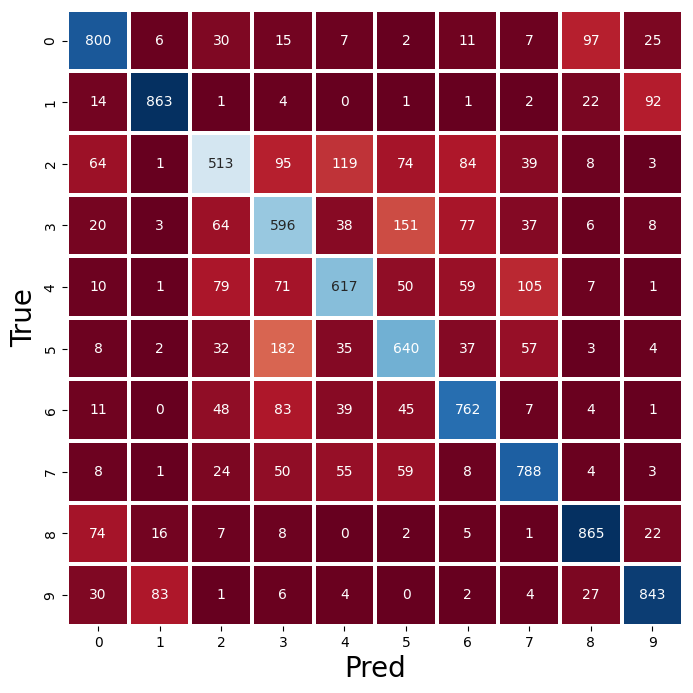

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

# Fine tuning with FedAvg (10000)

In [28]:
train_loader, test_loader, class_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, finedict, classes_dict, 1024
)
# train_loader, test_loader, class_loader = create_data_loaders_from_arrays(
#     train_X, train_y, test_X, test_y, traindict, classes_dict, 1024
# )

In [29]:
# Train fine-tuned model
p_bar = tqdm(range(epochs))
count = [0 for i in range(client_num)]
for epoch in range(epochs):
    # metrics = defaultdict(list)
    losses = []
    s_clients = []
    s_clients = random.sample(range(len(models)), 5)
    for idx in s_clients:
        models[idx].train()
        count[idx] += 1
        for step, (h, y) in enumerate(train_loader[idx]):
            h = h.to(device)
            y = y.to(device)
    
            outputs = models[idx](h)
    
            loss = criterion(outputs, y)
            optimizer_models[idx].zero_grad()
            loss.backward()
            optimizer_models[idx].step()
    
            # calculate accuracy and save metrics
            accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
            losses.append(loss.item())
            # metrics["Loss/train"].append(loss.item())
            # metrics["Accuracy/train"].append(accuracy)
    losses = np.array(losses)
    p_bar.set_description("Train Epoch: {epoch}/{epochs:4}.Loss: {loss:.4f}.".format(
            epoch=epoch,
            epochs=epochs,
            loss=losses.mean()))
    p_bar.update()
    # with torch.no_grad():
    #     for key in logreg.state_dict().keys():
    #         # num_batches_tracked is a non trainable LongTensor and
    #         # num_batches_tracked are the same for all clients for the given datasets
    #         if "running" in key or "num_batches" in key:
    #             continue
    #         # elif 'target' in key:
    #         #     continue
    #         else:
    #             temp = torch.zeros_like(logreg.state_dict()[key]).to('cuda')
    #             for client_idx in s_clients:
    #                 temp += models_weights[client_idx] * models[client_idx].state_dict()[key]                        
    #             logreg.state_dict()[key].data.copy_(temp)
    #             for client_idx in range(len(models)):
    #                 models[client_idx].state_dict()[key].data.copy_(logreg.state_dict()[key])
p_bar.close()


Train Epoch: 199/ 200.Loss: 3.2196.: 100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.69it/s]


In [30]:
count

[99, 104, 107, 85, 116, 92, 106, 106, 97, 88]

In [31]:
 # Test fine-tuned model
# resnet.eval()
acctol = []
labelall = {i : [] for i in range(len(models))}
predictall = {i : [] for i in range(len(models))}
print("### Calculating final testing performance ###")
metrics = defaultdict(list)
for idx in range(len(models)):
    models[idx].eval()
    acc = []
    for step, (h, y) in enumerate(test_loader):
        h = h.to(device)
        y = y.to(device)
    
        outputs = models[idx](h)
        # outputs = resnet(h)
        predictall[idx].append(outputs.argmax(1).cpu().numpy())
        labelall[idx].append(y.cpu().numpy())
        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
        # del outputs
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Client {idx} : Accuracy {acc.mean()}")

acctol = np.around(acctol, decimals=4)
# acctol = np.array(acctol)
print(f"Final test performance(noniid_ratio : {noniid_ratio}): Accuracy  : {acctol.mean()}")
print(f"Final test performance(noniid_ratio : {noniid_ratio}): " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


### Calculating final testing performance ###
Client 0 : Accuracy 45.74278539540816
Client 1 : Accuracy 42.84199617346938
Client 2 : Accuracy 43.07856345663265
Client 3 : Accuracy 41.94296077806122
Client 4 : Accuracy 43.09211575255102
Client 5 : Accuracy 40.73720503826531
Client 6 : Accuracy 42.34335140306122
Client 7 : Accuracy 43.42036033163265
Client 8 : Accuracy 43.0988919005102
Client 9 : Accuracy 42.511360012755105
Final test performance(noniid_ratio : 0.55): Accuracy  : 42.88098
Final test performance(noniid_ratio : 0.55): Fairness: 1.2047739346450026


In [32]:
std = []

models[0].eval()
label = []
predict = []
print("### Calculating classes testing performance ###")
metrics = defaultdict(list)
acctol = []
for idx in range(len(class_loader)):
    acc = []
    for step, (h, y) in enumerate(class_loader[idx]):
        h = h.to(device)
        y = y.to(device)
        

        outputs = models[0](h)
        
        predict.append(outputs.argmax(1).cpu().numpy())
        label.append(y.cpu().numpy())

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Class {idx} : Accuracy {acc.mean()}")
acctol = np.array(acctol)
std.append(acctol.std())
std = np.array(std)
print(f"Final test performance: " + "\t".join([f"{k}: {acctol.mean()}" for k, v in metrics.items()]))
print(f"Final test performance: " + "\t".join([f"Fairness: {std.mean()}" for k, v in metrics.items()]))

### Calculating classes testing performance ###
Class 0 : Accuracy 12.4
Class 1 : Accuracy 54.50000000000001
Class 2 : Accuracy 15.0
Class 3 : Accuracy 2.1
Class 4 : Accuracy 8.9
Class 5 : Accuracy 49.1
Class 6 : Accuracy 87.3
Class 7 : Accuracy 80.30000000000001
Class 8 : Accuracy 87.4
Class 9 : Accuracy 60.6
Final test performance: Accuracy/test: 45.760000000000005
Final test performance: Fairness: 32.06893200591501


In [33]:
clientid = 1
models[clientid].eval()
label = []
predict = []
print("### Calculating classes testing performance ###")
metrics = defaultdict(list)
acctol = []
for idx in range(len(class_loader)):
    acc = []
    for step, (h, y) in enumerate(class_loader[idx]):
        h = h.to(device)
        y = y.to(device)
        

        outputs = models[clientid](h)
        
        predict.append(outputs.argmax(1).cpu().numpy())
        label.append(y.cpu().numpy())

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Class {idx} : Accuracy {acc.mean()}")
acctol = np.array(acctol)
print(f"Final test performance: " + "\t".join([f"{k}: {acctol.mean()}" for k, v in metrics.items()]))
print(f"Final test performance: " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))

### Calculating classes testing performance ###
Class 0 : Accuracy 18.8
Class 1 : Accuracy 38.1
Class 2 : Accuracy 8.9
Class 3 : Accuracy 3.5999999999999996
Class 4 : Accuracy 6.800000000000001
Class 5 : Accuracy 29.799999999999997
Class 6 : Accuracy 87.6
Class 7 : Accuracy 84.89999999999999
Class 8 : Accuracy 87.4
Class 9 : Accuracy 62.7
Final test performance: Accuracy/test: 42.86
Final test performance: Fairness: 33.035623196785615


In [35]:
from sklearn.metrics import confusion_matrix
# predict = predict.flatten()
# label = label.flatten()
pre_y = predict[0]
test_y = label[0]
for arr in predict[1:]:
    # print(arr)
    pre_y = np.concatenate((pre_y, arr), axis=0)
for arr in label[1:]:
    # print(arr)
    test_y = np.concatenate((test_y, arr), axis=0)
print(pre_y)
cm=confusion_matrix(test_y,pre_y)

[0 7 0 ... 9 9 9]


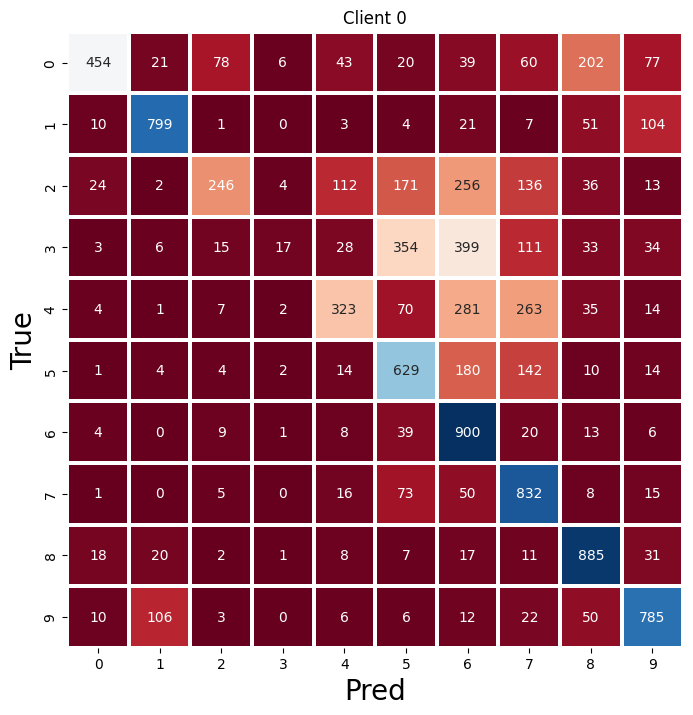

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.title(f'Client {clientid}')
plt.xlabel('Pred',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.show()

# Fine tuning by IID or non-IID data (10000 per client)

In [ ]:
 # Test fine-tuned model
# logreg.eval()
resnet.eval()
acctol = []
for idx in range(len(test_loader)):
    print("### Calculating final testing performance ###")
    metrics = defaultdict(list)
    # for idx in range(len(test_loader)):
    acc = []
    for step, (h, y) in enumerate(test_loader[idx]):
        h = h.to(device)
        y = y.to(device)

        # outputs = logreg(h)
        outputs = resnet(h)

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Client {idx} : Accuracy {acc.mean()}")
    
acctol = np.array(acctol)
print(f"Final test performance(noniid_ratio : {noniid_ratio}): Accuracy  : {acctol.mean()}")
print(f"Final test performance(noniid_ratio : {noniid_ratio}): " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))

    
    
